In [237]:
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler


In [238]:
bioclim = pd.read_csv('data/csv/bioclim.csv')
bioclim = bioclim.drop(columns=['Unnamed: 0'])

In [239]:
crta_coords_filtered = pd.read_csv('data/csv/crta_coords_filtered.csv')
crta_coords_filtered.columns = ['lat', 'lon']
bioclim = pd.merge(bioclim, crta_coords_filtered, on=['lat', 'lon'])
bioclim = bioclim.drop_duplicates(subset=['lat', 'lon'])
bioclim = bioclim[bioclim['bio_13']!=-3.4e+38]
bioclim = bioclim[bioclim['elev']> 0]
bioclim['elev'] = np.log(bioclim['elev'] + 1)
coords = bioclim[['lat', 'lon']]
bioclim = bioclim.drop(columns=['lat', 'lon'])
# bioclim['group'] = 'osmia'

In [240]:
america = pd.read_csv('data/csv/10k_america_bioclim_ndvi.csv', index_col=None)
america = america.drop(columns=['Unnamed: 0'])
america = america[america['bio_13']!= -3.4e+38]
america = america[america['elev']> 0]
america['elev'] = np.log(america['elev'] + 1) 
america_points = america[['lat', 'lon']]
america = america.drop(columns=['lat', 'lon'])
# america['group'] = 'america'
column_order = bioclim.columns.tolist()
america = america[column_order]

In [241]:
bio_columns = [col for col in america.columns if col.startswith('bio_')]
other_columns = [col for col in america.columns if not col.startswith('bio_')]
bio_columns_sorted = sorted(bio_columns, key=lambda x: (x.split('_')[0], int(x.split('_')[1])))
other_columns_sorted = sorted(other_columns)
sorted_columns = bio_columns_sorted + other_columns_sorted
america = america[sorted_columns]
osmia = bioclim[sorted_columns]

In [242]:
keep_cols = ['bio_1', 'bio_4', 'bio_6', 'bio_7', 'bio_10', 'bio_11', 'bio_12', 'bio_13', 'bio_14']

In [243]:
# # NO MEAN SUBTRACT
# america_df = america.copy()
# osmia_df = osmia.copy()

In [244]:
# # MEAN SUBTRACT ONLY

# america_means = america.mean()
# america_df = america - america_means

# osmia_means = osmia.mean()
# osmia_df = osmia - osmia_means

In [245]:
america_df = america_df[keep_cols]
osmia_df = osmia [keep_cols]

In [246]:
osmia_df.describe()

,bio_1,bio_4,bio_6,bio_7,bio_10,bio_11,bio_12,bio_13,bio_14
count,6075.000000,6075.000000,6075.000000,6075.000000,6075.000000,6075.000000,6075.000000,6075.000000,6075.000000
mean,10.009688,624.651607,-0.948856,24.840774,17.816422,2.525564,774.406914,84.391770,46.286584
std,1.356123,75.678414,1.876418,2.535589,1.560124,1.817177,157.878150,19.633771,12.097195
min,-0.629167,363.726500,-11.000000,15.400001,5.883333,-6.516667,328.000000,41.000000,1.000000
25%,9.325000,566.954170,-2.000000,22.900000,16.900000,1.400000,668.000000,73.000000,40.000000
50%,9.900000,615.575600,-0.800000,24.500000,17.450000,2.566667,772.000000,79.000000,46.000000
75%,10.416667,665.625000,0.250000,26.199999,18.391666,3.500000,836.000000,91.000000,53.000000
max,18.087500,1162.149500,8.000000,40.200000,25.233334,11.600000,1921.000000,234.000000,129.000000


In [247]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(osmia)

osmia_df = pd.DataFrame(scaler.transform(osmia), columns=osmia.columns)
america_df = pd.DataFrame(scaler.transform(america), columns=osmia.columns)

In [248]:
# plt.figure(figsize=(10, 5 * len(osmia_df.columns)))

# for i, column in enumerate(osmia_df.columns):
#     plt.subplot(len(osmia_df.columns), 1, i + 1)
#     osmia_df[column].hist(bins=20)
#     plt.title(f'Histogram of {column}')
# plt.tight_layout()
# plt.savefig('figures/histograms/mahal_notscaled_data_distributions.png', format='png', dpi=300)

In [249]:
# combined = pd.concat([bioclim, america], ignore_index=True)
# combined_points = pd.concat([coords, america_points])

In [250]:
# combined.describe()

In [251]:
# combined_vars = combined.drop(columns=['group'])
# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(combined_vars)
# combined_scaled = pd.DataFrame(df_scaled, columns=combined_vars.columns)
# combined_scaled['group'] = combined['group']

In [252]:
# america_df = combined_scaled[combined_scaled['group'] == 'america'].drop('group', axis=1)
# osmia_df = combined_scaled[combined_scaled['group'] == 'osmia'].drop('group', axis=1)

In [253]:
from scipy.spatial import distance
from scipy.stats import chi2

osmia_mean = osmia_df.mean()
osmia_cov = osmia_df.cov()

def mahalanobis_distance(x, mean, cov):
    x_minus_mu = x - mean
    cov_inv = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, cov_inv)
    mahal = np.dot(left_term, x_minus_mu.T)
    return np.sqrt(mahal)

mahal_distances = america_df.apply(lambda x: mahalanobis_distance(x, osmia_mean, osmia_cov), axis=1)

In [254]:
mahal_distances = mahal_distances.reset_index(drop=True)

In [255]:
from scipy.stats import chi2

degrees_freedom = osmia_df.shape[1]
chi_sq = 1 - chi2.cdf(mahal_distances, degrees_freedom)

In [256]:
chi_sq

array([0.00464388, 0.00176078, 0.03721723, ..., 0.00801942, 0.01009283,
       0.00954349])

In [257]:
mahal_distances_eur = osmia_df.apply(lambda x: mahalanobis_distance(x, osmia_mean, osmia_cov), axis=1)

Text(0.5, 1.0, 'distribution of mahal distances, america to eur')

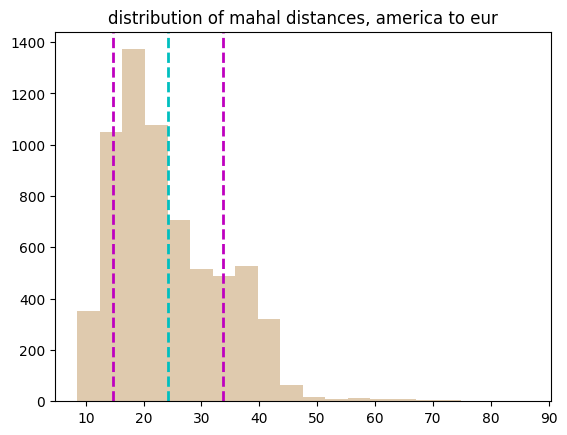

In [258]:
mean = np.mean(mahal_distances)
std_dev = np.std(mahal_distances)

plt.hist(mahal_distances, bins=20, alpha=0.7, color='tan')
plt.axvline(mean, color='c', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(mean + std_dev, color='m', linestyle='dashed', linewidth=2, label='+1 STD')
plt.axvline(mean - std_dev, color='m', linestyle='dashed', linewidth=2, label='-1 STD')
plt.title('distribution of mahal distances, america to eur')


(array([1379.,  370.,  292.,  260.,  204.,  233.,  214.,  243.,  262.,
         251.,  254.,  279.,  271.,  298.,  296.,  253.,  317.,  320.,
         276.,  263.]),
 array([6.45221432e-10, 4.96159718e-02, 9.92319429e-02, 1.48847914e-01,
        1.98463885e-01, 2.48079856e-01, 2.97695827e-01, 3.47311798e-01,
        3.96927770e-01, 4.46543741e-01, 4.96159712e-01, 5.45775683e-01,
        5.95391654e-01, 6.45007625e-01, 6.94623596e-01, 7.44239567e-01,
        7.93855539e-01, 8.43471510e-01, 8.93087481e-01, 9.42703452e-01,
        9.92319423e-01]),
 <BarContainer object of 20 artists>)

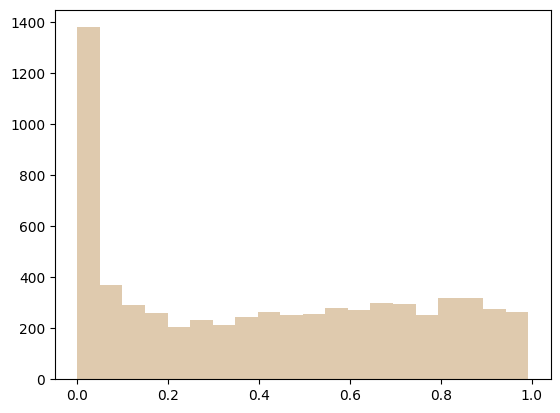

In [259]:
plt.hist(chi_sq, bins=20, alpha=0.7, color='tan')

Text(0.5, 1.0, 'distribution of mahal distances, eur to eur')

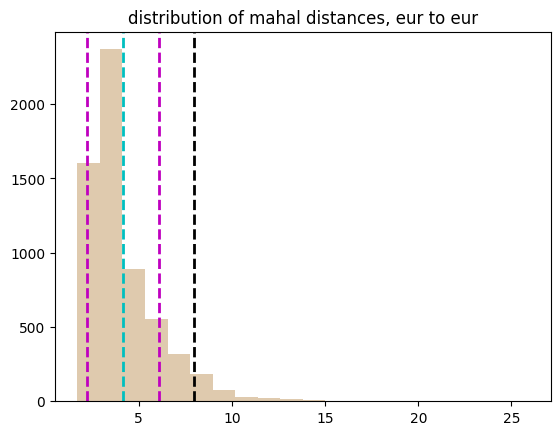

In [260]:
mean = np.mean(mahal_distances_eur)
std_dev = np.std(mahal_distances_eur)
z = 1.96
upper_bound = mean + z * std_dev

plt.hist(mahal_distances_eur, bins=20, alpha=0.7, color='tan')
plt.axvline(mean, color='c', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(mean + std_dev, color='m', linestyle='dashed', linewidth=2, label='+1 STD')
plt.axvline(mean - std_dev, color='m', linestyle='dashed', linewidth=2, label='-1 STD')
plt.axvline(upper_bound, color='k', linestyle='dashed', linewidth=2, label='-1 STD')
plt.title('distribution of mahal distances, eur to eur')


In [261]:
upper_bound

7.94838034857202

In [262]:
min(mahal_distances)

8.552506439826528

In [263]:
america_points = america_points.reset_index(drop=True)
america_points['dist'] = mahal_distances
america_points['chi'] = chi_sq
# america_points.to_csv('america_points_mahal.csv')

In [264]:
crta_coords_filtered = crta_coords_filtered.reset_index(drop=True)
mahal_distances_eur = mahal_distances_eur.reset_index(drop=True)

crta_coords_filtered['dist'] = mahal_distances_eur

(-14641852.624039328, -6841695.90415462, 2746944.401339209, 7307496.882081329)

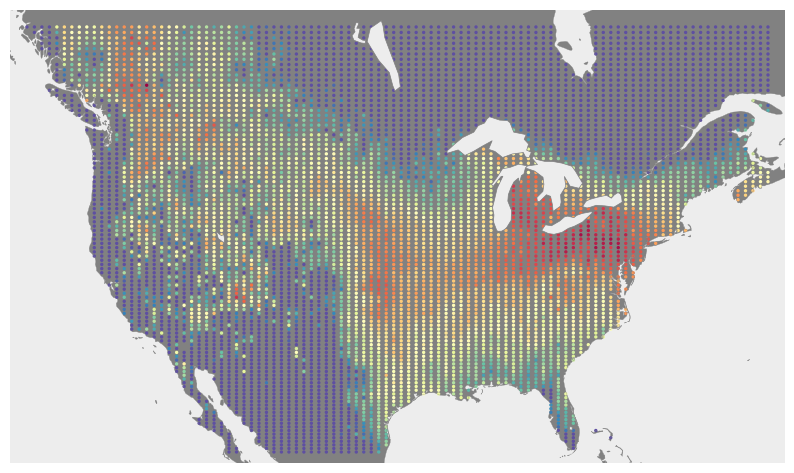

In [265]:
import geopandas as gpd
from shapely.geometry import Point
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt

extent = [-131.53, -61.46, 24.09, 54.90]
map_projection = ccrs.Mercator() 
great_lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')
shapefile_path = 'data/shapefiles/ne_110m_land/ne_110m_land.shp'
gdf = gpd.read_file(shapefile_path)
lakes_shapefile_path = 'data/shapefiles/ne_110m_lakes/ne_110m_lakes.shp'
lakes_gdf = gpd.read_file(lakes_shapefile_path)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': map_projection})
ax.set_extent(extent, crs=ccrs.PlateCarree()) 
ax.add_feature(cfeature.LAND, facecolor='#818181', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

ax.scatter(america_points['lon'], america_points['lat'], transform=ccrs.PlateCarree(), 
           c=america_points['dist'], cmap='Spectral', vmin=min(mahal_distances), vmax = max(mahal_distances_eur), s=2)

ax.axis('off')



(-14641852.624039328, -6841695.90415462, 2746944.401339209, 7307496.882081329)

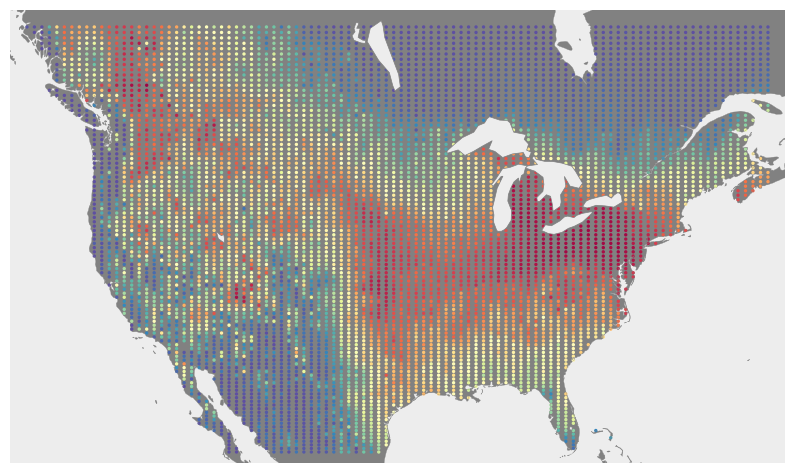

In [266]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': map_projection})
ax.set_extent(extent, crs=ccrs.PlateCarree()) 
ax.add_feature(cfeature.LAND, facecolor='#818181', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

ax.scatter(america_points['lon'], america_points['lat'], transform=ccrs.PlateCarree(), 
           c=america_points['chi'], cmap='Spectral_r', vmin=0, vmax =1, s=2)

ax.axis('off')

In [267]:
# crta_coords_filtered

In [268]:
# plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# ax = plt.gca()

# ax.add_feature(cfeature.LAND, facecolor='#818181', edgecolor='gray', linewidth=.5)
# ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
# ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
# ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

# ax.scatter(crta_coords_filtered['lon'], crta_coords_filtered['lat'], transform=ccrs.PlateCarree(), 
#            c=crta_coords_filtered['dist'], s=2, cmap='Spectral', vmin=2, vmax = 8)
# ax.axis('off')

# plt.savefig('eur_mahal.png', format='png', dpi=300)

In [269]:
# cities = {
#     "Amsterdam": (52.3676, 4.9041),
#     "Brussels": (50.8503, 4.3517),
# }

# plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# ax = plt.gca()

# extent = [2, 8, 49, 53]

# ax.set_extent(extent, crs=ccrs.PlateCarree())  # Adjust as needed
# ax.add_feature(cfeature.LAND, facecolor='#818181', edgecolor='gray', linewidth=.5)
# ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
# ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
# ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

# ax.scatter(crta_coords_filtered['lon'], crta_coords_filtered['lat'], transform=ccrs.PlateCarree(), 
#            c=crta_coords_filtered['dist'], s=2, cmap='Spectral', vmin=2, vmax = 8)
# ax.axis('off')


# for city, (lat, lon) in cities.items():
#     ax.plot(lon, lat, 'o', markersize=1, color='k', transform=ccrs.Geodetic())
#     ax.text(lon + .01, lat + 0, city, transform=ccrs.Geodetic())
